##Import libraries and data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
df1 = pd.read_csv('2019 income data by county.csv', encoding='latin-1', thousands=',')
df2 = pd.read_csv('co-est2019-alldata.csv', encoding='latin-1', thousands=',')
df3 = pd.read_csv('Table_10_Offenses_Known_to_Law_Enforcement_by_State_by_Metropolitan_and_Nonmetropolitan_Counties_2019.csv', thousands=',')

##Data cleaning
Some data cleaning done in Excel, including use of VLookup.

In [3]:
df1 = df1[df1.LineCode == 3]
df1['State1'] = df1['State1'].str.strip()
df1['County'] = df1['County'].str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


##Join data sets

In [4]:
from functools import reduce
data_frames = [df3, df1, df2]
data = reduce(lambda  left,right: pd.merge(left,right,on=['County', 'State1'],
                                            how='outer', validate = 'many_to_many'), data_frames)

In [5]:
data = data.rename(columns={'Violent\ncrime': 'Violent crime'})

##Removing missing data

In [6]:
data = data.dropna(subset=['2019', 'Metro', 'POPESTIMATE2019', 'Violent crime'])

In [7]:
data.head(10)

,State,State1,Metro,County,Violent crime,Murder and \nnon negligent \nmanslaughter,Rape,Robbery,Aggravated \nassault,Property \ncrime,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,ARIZONA,AZ,1.0,Cochise,47.0,0.0,1.0,3.0,43.0,531.0,...,-4.715990,5.465822,-12.002384,-22.079933,-21.690049,-9.686012,-7.773459,-7.224107,12.567904,-4.192872
1,ARIZONA,AZ,1.0,Coconino,127.0,6.0,17.0,1.0,103.0,264.0,...,2.188819,-10.606686,6.123785,-2.741483,-0.495871,3.623503,4.803683,-0.547248,6.447426,2.363645
2,ARIZONA,AZ,1.0,Mohave,135.0,3.0,6.0,19.0,107.0,1983.0,...,22.416620,14.124616,5.987803,3.380298,5.071959,10.539293,10.371086,14.606150,18.370970,21.249285
3,ARIZONA,AZ,1.0,Pinal,197.0,3.0,5.0,18.0,171.0,1469.0,...,31.178711,-9.572930,5.763575,2.792943,20.012296,21.175225,24.445587,30.618893,31.786149,32.249518
4,ARIZONA,AZ,1.0,Yavapai,193.0,5.0,0.0,4.0,184.0,860.0,...,19.859876,3.957093,8.467405,15.154393,19.137449,17.919324,21.662401,20.889990,22.133112,19.551439
5,ARIZONA,AZ,1.0,Yuma,136.0,7.0,17.0,6.0,106.0,807.0,...,1.678424,18.906513,-11.132055,-9.049260,-0.792179,-2.326263,2.744688,3.503266,3.452706,4.245426
6,ARIZONA,AZ,0.0,Gila,176.0,1.0,3.0,5.0,167.0,384.0,...,9.349002,-1.644844,-6.257399,1.490580,3.168347,2.207089,11.604943,8.210672,8.623660,9.515948
7,ARIZONA,AZ,0.0,Graham,61.0,4.0,0.0,0.0,57.0,104.0,...,15.800708,-8.077762,-10.412592,3.626692,7.943653,-14.297187,-8.881018,-16.124748,8.850496,16.581633
8,ARIZONA,AZ,0.0,La Paz,40.0,1.0,2.0,3.0,34.0,310.0,...,5.836714,5.547310,-2.285714,2.826304,1.559530,0.244010,11.674855,7.592978,21.607378,9.063516
9,ARIZONA,AZ,0.0,Navajo,43.0,1.0,0.0,5.0,37.0,341.0,...,2.812367,-9.282273,-8.852070,-7.638215,-0.558566,-6.259897,2.674626,1.296278,7.796791,3.210258


In [ ]:
#compression_opts = dict(method='zip',
#                       archive_name='out.csv')  
#data.to_csv('out.zip', index=False,
#          compression=compression_opts)

##Create X and y variables

In [8]:
X = data[['2019', 'POPESTIMATE2019', 'Metro']].values
X = np.asarray(X).astype(np.float32)
y = data['Violent crime'].values

In [9]:
print(X)

[[4.05460e+04 1.25922e+05 1.00000e+00]
 [4.88370e+04 1.43476e+05 1.00000e+00]
 [3.42740e+04 2.12181e+05 1.00000e+00]
 ...
 [4.13920e+04 2.02260e+04 0.00000e+00]
 [5.11380e+04 7.80500e+03 0.00000e+00]
 [4.66580e+04 6.92700e+03 0.00000e+00]]


##Income Visualization

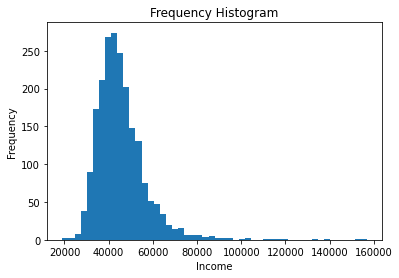

In [10]:
plt.hist(X[:, 0], bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='Income');

##Split into training and test set

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##Feature Scaling

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, :2] = sc.fit_transform(X_train[:, :2])
X_test[:, :2] = sc.transform(X_test[:, :2])

##Regression models

###Multiple linear regression

In [9]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

###Support vector regression

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

SVR()

###Random forest regression

In [12]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

###XGBoost

In [13]:
from xgboost import XGBRegressor
regressor = XGBRegressor(objective='reg:squarederror')
regressor.fit(X_train, y_train)

XGBRegressor(objective='reg:squarederror')

###Artificial neural network

In [ ]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=9, input_dim=3, activation='relu'))
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
ann.add(tf.keras.layers.Dense(units=9, activation='tanh'))
ann.add(tf.keras.layers.Dense(units=1))
ann.compile(loss='mean_squared_error', optimizer='adam', metrics = ['Accuracy'])

In [10]:
ann.fit(X_train, y_train, batch_size = 32, epochs = 150)

NameError: ignored

###Predicting test set results

In [14]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[3.73e+01 6.00e+00]
 [1.45e+01 1.50e+01]
 [1.37e+02 5.00e+01]
 [4.35e+01 2.20e+01]
 [3.55e+01 6.00e+00]
 [2.40e+01 1.20e+01]
 [9.61e+00 2.00e+00]
 [5.75e+01 1.00e+01]
 [3.17e+01 9.00e+00]
 [1.09e+02 3.10e+02]
 [3.73e+01 3.60e+01]
 [1.14e+02 5.35e+03]
 [1.84e+01 3.30e+01]
 [6.34e+02 2.00e+01]
 [5.84e+01 6.20e+01]
 [2.84e+02 0.00e+00]
 [2.22e+01 0.00e+00]
 [5.50e+01 5.10e+01]
 [6.06e+00 0.00e+00]
 [5.49e+01 1.93e+02]
 [5.62e+00 5.00e+00]
 [8.71e+01 6.40e+01]
 [1.37e+01 5.00e+00]
 [1.03e+01 1.10e+01]
 [8.35e+01 5.70e+01]
 [6.53e+01 2.20e+01]
 [1.17e+02 1.21e+02]
 [2.99e+01 4.60e+01]
 [1.55e+01 1.30e+01]
 [1.40e+01 3.00e+01]
 [1.26e+01 1.20e+01]
 [1.15e+01 2.00e+00]
 [1.47e+01 5.00e+00]
 [2.72e+01 5.50e+01]
 [1.61e+02 5.60e+01]
 [1.15e+01 7.00e+00]
 [2.66e+01 1.40e+01]
 [1.41e+01 8.00e+00]
 [1.46e+01 7.00e+00]
 [1.64e+02 3.50e+01]
 [6.53e+01 4.00e+00]
 [1.94e+01 2.00e+00]
 [1.26e+01 5.00e+00]
 [1.15e+01 9.00e+00]
 [5.55e+00 9.00e+00]
 [1.04e+01 6.00e+00]
 [2.05e+01 5.20e+01]
 [9.60e+01 4.

###Computing R2 value
Unfortunately, the R2 value fluctuates wildly based on the random nature of the test / train split.

In [16]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

-0.8008078649774761

###Applying K-Fold cross validation
Applying K-Fold cross validation shows a RSME of about 250 - 300, depending on the model, which is extremely high. The models are, unfortunately, not very predictive due to the drastic variation levels.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt

In [18]:
scores = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10, scoring='neg_mean_squared_error')
sqrt(mean(absolute(scores)))

248.47637031998894

###SHAP Plots

In [21]:
pip install shap

     |████████████████████████████████| 564 kB 7.6 MB/s 


In [23]:
import shap
explainer = shap.Explainer(regressor)
shap_values = explainer(X_test)

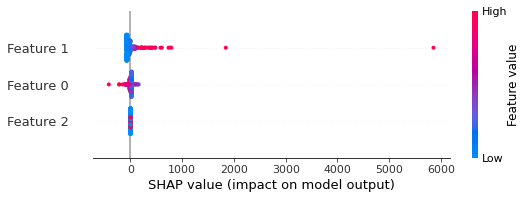

In [25]:
shap.plots.beeswarm(shap_values)

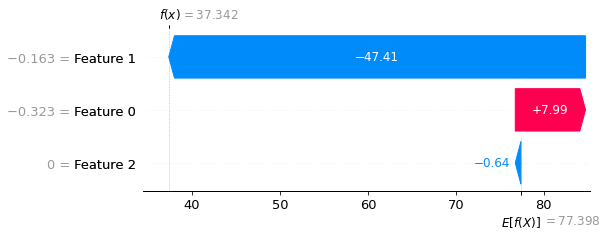

In [26]:
shap.plots.waterfall(shap_values[0])